# Making El Nino Animations

El Nino is the warm phase of __[El Niño–Southern Oscillation (ENSO)](https://en.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Southern_Oscillation)__. It is a part of a routine climate pattern that occurs when sea surface temperatures in the tropical Pacific Ocean rise to above-normal levels for an extended period of time.

In this Notebook we show how to make animations of sea surface temperature anomalies using __[NOAA 1/4° Daily Optimum Interpolation Sea Surface Temperature (Daily OISST) dataset (NOAA OISST](https://data.planetos.com/datasets/noaa_oisst_daily_1_4)__


_API documentation is available at http://docs.planetos.com. If you have questions or comments, join the Planet OS Slack community to chat with our development team. For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/_

__This Notebook is running on Python3.__

In [1]:
import os
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import imageio
import shutil
import datetime
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Avenir Lt Std'
mpl.rcParams.update({'font.size': 25})

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
API_key = open('APIKEY').read().strip()
server='api.planetos.com/'
version = 'v1'

This is a part where you should change the time period if you want to get animation of different time frame. Strongest __[El Nino years](http://ggweather.com/enso/oni.htm)__  have been 1982-83, 1997-98 and 2015-16. However, El Nino have occured more frequently. NOAA OISST dataset in Planet OS Datahub starts from 2008, however, we can extend the period if requested (since 1981 September). Feel free to change time_start and time_end to see how anomalies looked like on different years. You can find year when El Nino was present from __[here](http://ggweather.com/enso/oni.htm)__.

In [3]:
time_start = '2016-01-01T00:00:00'
time_end = '2016-03-10T00:00:00'
dataset_key = 'noaa_oisst_daily_1_4'
variable = 'anom'
area = 'pacific'
latitude_north = 40;  latitude_south = -40
longitude_west = -180; longitude_east = -77
anim_name = variable + '_animation_' + str(datetime.datetime.strptime(time_start,'%Y-%m-%dT%H:%M:%S').year) + '.mp4'    

## Download the data with package API
- Create package objects
- Send commands for the package creation
- Download the package files


In [4]:
dh=datahub.datahub(server,version,API_key)
package = package_api.package_api(dh,dataset_key,variable,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,area_name=area)
package.make_package()
package.download_package()

Package exists


Here we are using xarray to read in the data. We will also rewrite longitude coordinates as they are from 0-360 at first, but Basemap requires longitude -180 to 180. 

In [5]:
dd1 = xr.open_dataset(package.local_file_name)
dd1['lon'] = ((dd1.lon+180) % 360) - 180

We like to use Basemap to plot data on it. Here we define the area. You can find more information and documentation about Basemap __[here](https://matplotlib.org/basemap/)__.

In [6]:
m = Basemap(projection='merc', lat_0 = 0, lon_0 =  (longitude_east + longitude_west)/2,
         resolution = 'l', area_thresh = 0.05,
         llcrnrlon=longitude_west, llcrnrlat=latitude_south,
         urcrnrlon=longitude_east, urcrnrlat=latitude_north)

lons,lats = np.meshgrid(dd1.lon,dd1.lat)
lonmap,latmap = m(lons,lats)

Below we make local folder where we save images. These are the images we will use for animation. No worries, in the end, we will delete the folder from your system. 

In [7]:
folder = './ani/'
if not os.path.exists(folder):
    os.mkdir(folder)

Now it is time to make images from every time step. Let's also show first time step here:

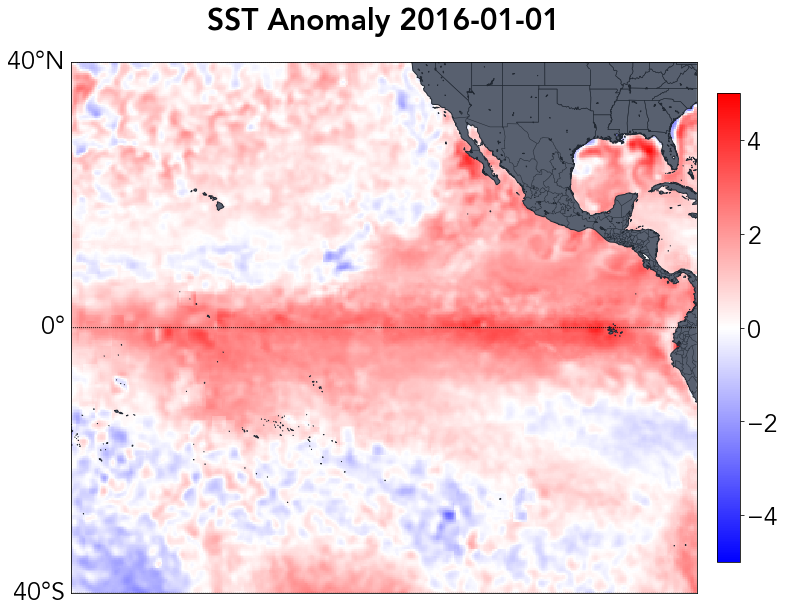

In [8]:
vmin = -5; vmax = 5
for k in range(0,len(dd1[variable])):
    filename = folder + 'ani_' + str(k).rjust(3,'0') + '.png'
    
    fig=plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    pcm = m.pcolormesh(lonmap,latmap,dd1[variable][k,0].data,vmin = vmin, vmax = vmax,cmap='bwr')
    m.fillcontinents(color='#58606F')
    m.drawcoastlines(color='#222933')
    m.drawcountries(color='#222933')
    m.drawstates(color='#222933')
    parallels = np.arange(-40.,41,40)
    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,False,True,False])
    #meridians = np.arange(10.,351.,2.)
    #m.drawmeridians(meridians,labels=[True,False,False,True])
    cbar = plt.colorbar(pcm,fraction=0.035, pad=0.03)
    ttl = plt.title('SST Anomaly ' + str(dd1[variable].time[k].data)[:-19],fontweight = 'bold')
    ttl.set_position([.5, 1.05])
    if not os.path.exists(folder):
        os.mkdir(folder)
    plt.savefig(filename)
    if k == 0:
        plt.show()
    plt.close()
    

This is part where we are making animation. 

In [9]:
files = sorted(os.listdir(folder))
fileList = []
for file in files:
    if not file.startswith('.'):
        complete_path = folder + file
        fileList.append(complete_path)

writer = imageio.get_writer(anim_name, fps=4)

for im in fileList:
    writer.append_data(imageio.imread(im))
writer.close()
print ('Animation is saved as ' + anim_name + ' under current working directory')

Animation is saved as anom_animation_2016.mp4 under current working directory


And finally, we will delete folder where images where saved. Now you just have animation in your working directory. 

In [10]:
shutil.rmtree(folder)